# Final project FDS

Bone fracture detection on x-ray images using a CNN.

Group members: Aiman Nadeem, Thale Krohn-Pettersen, Kirsten Nord.

**Table of contents**
1. [Setup and data preprocessing](#setup)
2. [CNN model](#cnn)
3. [Baseline MLP model](#baseline)
4. [Analysis](#analysis)

## Setup and data preprocessing <a name="setup"></a>

- Installing required packages
- Importing necessary libraries
- Downloading dataset and re-splitting the dataset into 80% training, 10% validation and 10% testing.
- Create datagenerators

In [43]:
if True:
    %pip install kagglehub scikit-learn tensorflow pillow matplotlib keras-tuner

Note: you may need to restart the kernel to use updated packages.


In [49]:
# Import the required libraries
import os
import random
import shutil
import kagglehub
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import keras_tuner as kt
import keras

# Set seeds for reproducibility
tf.random.set_seed(42)
random.seed(42)

In [4]:
# Download the dataset from Kaggle
dataset_path = kagglehub.dataset_download("osamajalilhassan/bone-fracture-dataset")
print(f"Dataset downloaded to {dataset_path}")

Dataset downloaded to C:\Users\aiman\.cache\kagglehub\datasets\osamajalilhassan\bone-fracture-dataset\versions\1


In [ ]:
def is_image_file(filename):
    return filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff'))

def split_dataset(dataset_path, output_path, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):
    os.makedirs(output_path, exist_ok=True)  # Ensure output directory exists

    splits = ['training', 'testing']
    categories = ['fractured', 'not_fractured']

    for split in splits:
        for category in categories:
            class_dir = os.path.join(dataset_path, split, category)
            
            # Get all image files in the category
            images = [f for f in os.listdir(class_dir) if is_image_file(f)]
            random.shuffle(images)

            # Calculate split sizes
            train_end = int(len(images) * train_ratio)
            val_end = train_end + int(len(images) * val_ratio)

            train_images = images[:train_end]
            val_images = images[train_end:val_end]
            test_images = images[val_end:]

            # Create subdirectories for train, val, test
            for split_name, split_images in zip(
                ['train', 'val', 'test'], [train_images, val_images, test_images]
            ):
                split_dir = os.path.join(output_path, split_name, category)
                os.makedirs(split_dir, exist_ok=True)

                # Copy images to respective split folder
                for image in split_images:
                    src = os.path.join(class_dir, image)
                    dst = os.path.join(split_dir, image)
                    try:
                        shutil.copy(src, dst)
                    except PermissionError as e:
                        print(f"Skipping {src} due to permission error: {e}")
                        
    print(f"Dataset split into train, validation, and test sets at {output_path}")

# Perform the dataset split
dataset_path = dataset_path + "/BoneFractureDataset"
output_path = "data"
split_dataset(dataset_path, output_path)

In [18]:
def count_images_in_split(split_path):
    # Count the number of image files in a given split directory (train, val, or test)
    total_images = 0
    for category in ['fractured', 'not_fractured']:
        category_path = os.path.join(split_path, category)
        if os.path.exists(category_path):
            category_images = os.listdir(category_path)
            total_images += len(category_images)
    return total_images

def verify_split(output_path):
    # Verify the directory structure and the number of images in each split
    splits = ['train', 'val', 'test']
    print("Verifying dataset split...")

    for split in splits:
        split_path = os.path.join(output_path, split)
        if os.path.exists(split_path):
            print(f"Number of images in {split} split:")
            num_images = count_images_in_split(split_path)
            print(f"  Total images in {split}: {num_images}")
        else:
            print(f"  No {split} directory found!")

# Perform the verification
verify_split(output_path)

Verifying dataset split...
Number of images in train split:
  Total images in train: 7570
Number of images in val split:
  Total images in val: 946
Number of images in test split:
  Total images in test: 947


In [6]:
base_dir = output_path
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

In [45]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,  # Normalize pixel values to [0, 1]
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),  # Resize images to 150x150
    batch_size=32,
    class_mode='binary'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

Found 7570 images belonging to 2 classes.
Found 946 images belonging to 2 classes.
Found 947 images belonging to 2 classes.


## CNN Model <a name="cnn"></a>

- Define the CNN model, first without hyperparameter tuning
- Train the model
- After, define the model with hyperparameter tuning and search for the best parameters

In [50]:
model = Sequential([
    Input(shape=(150, 150, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification: fractured or not
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

In [51]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

Epoch 1/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 90s 368ms/step - accuracy: 0.5430 - loss: 0.6912 - precision_2: 0.5444 - recall_2: 0.3167 - val_accuracy: 0.6036 - val_loss: 0.6394 - val_precision_2: 0.5608 - val_recall_2: 0.8680
Epoch 2/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 87s 367ms/step - accuracy: 0.5607 - loss: 0.6744 - precision_2: 0.5476 - recall_2: 0.5392 - val_accuracy: 0.6268 - val_loss: 0.6185 - val_precision_2: 0.5734 - val_recall_2: 0.9221
Epoch 3/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 89s 374ms/step - accuracy: 0.5940 - loss: 0.6540 - precision_2: 0.5666 - recall_2: 0.7107 - val_accuracy: 0.6934 - val_loss: 0.5896 - val_precision_2: 0.6410 - val_recall_2: 0.8463
Epoch 4/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 88s 370ms/step - accuracy: 0.6050 - loss: 0.6447 - precision_2: 0.5787 - recall_2: 0.6883 - val_accuracy: 0.6829 - val_loss: 0.5777 - val_precision_2: 0.6286 - val_recall_2: 0.8571
Epoch 5/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 90s 378ms/step - accuracy: 0.6509 - loss: 0.6147 - precision_2: 0.6188 - rec

In [52]:
def build_model(hp):
    model = Sequential([
        Input(shape=(150, 150, 3)),
        Conv2D(
            filters=hp.Int('filters_1', min_value=32, max_value=64, step=32), 
            kernel_size=(3, 3), 
            activation='relu'
        ),
        MaxPooling2D((2, 2)),

        Conv2D(
            filters=hp.Int('filters_2', min_value=64, max_value=128, step=64), 
            kernel_size=(3, 3), 
            activation='relu'
        ),
        MaxPooling2D((2, 2)),

        Conv2D(
            filters=hp.Int('filters_3', min_value=128, max_value=256, step=128), 
            kernel_size=(3, 3), 
            activation='relu'
        ),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(
            units=hp.Int('dense_units', min_value=64, max_value=128, step=64), 
            activation='relu'
        ),
        Dropout(rate=0.5),
        Dense(1, activation='sigmoid')  # Binary classification: fractured or not
    ])
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', Precision(), Recall()]
    )
    return model

In [53]:
# Initialize the tuner
tuner = kt.Hyperband(
    build_model, 
    objective='val_recall',
    max_epochs=5,
    hyperband_iterations=1,
    directory='tuner_dir',
    project_name='bone_fracture_classification'
)

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Search for the best hyperparameters
tuner.search(
    train_generator, 
    epochs=5,
    validation_data=val_generator,
    callbacks=[early_stopping]
)

Reloading Tuner from tuner_dir\bone_fracture_classification\tuner0.json


In [54]:
# Retrieve and fine tune the best model
best_model = tuner.get_best_models(num_models=1)[0]

cnn_history = best_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_recall', patience=3, restore_best_weights=True)
    ]
)

Epoch 1/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 104s 430ms/step - accuracy: 0.6606 - loss: 0.5997 - precision: 0.6272 - recall: 0.7616 - val_accuracy: 0.7336 - val_loss: 0.5416 - val_precision: 0.7917 - val_recall: 0.6169
Epoch 2/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 99s 416ms/step - accuracy: 0.7090 - loss: 0.5579 - precision: 0.6716 - recall: 0.8039 - val_accuracy: 0.7822 - val_loss: 0.4635 - val_precision: 0.8005 - val_recall: 0.7381
Epoch 3/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 102s 430ms/step - accuracy: 0.7239 - loss: 0.5355 - precision: 0.6867 - recall: 0.7792 - val_accuracy: 0.8203 - val_loss: 0.4183 - val_precision: 0.7645 - val_recall: 0.9134
Epoch 4/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 105s 444ms/step - accuracy: 0.7411 - loss: 0.5182 - precision: 0.7004 - recall: 0.7983 - val_accuracy: 0.8425 - val_loss: 0.3827 - val_precision: 0.8087 - val_recall: 0.8874
Epoch 5/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 107s 449ms/step - accuracy: 0.7569 - loss: 0.4842 - precision: 0.7237 - recall: 0.8202 - val_accuracy: 0.

In [55]:
best_model.save('best_fracture_classifier.keras')

## Baseline MLP Model<a name="baseline"></a>

- Create a simple MLP model as a baseline for comparison

In [65]:
# MLP Baseline Model
mlp_model = Sequential([
    Input(shape=(150, 150, 3)),
    Flatten(),
    Dense(1, activation='sigmoid')
])

mlp_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

# Training and validation
mlp_history = mlp_model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

Epoch 1/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 35s 145ms/step - accuracy: 0.5213 - loss: 1.3602 - precision_2: 0.5092 - recall_2: 0.5139 - val_accuracy: 0.4958 - val_loss: 0.8588 - val_precision_2: 0.4324 - val_recall_2: 0.1039
Epoch 2/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 34s 144ms/step - accuracy: 0.5246 - loss: 0.9231 - precision_2: 0.5131 - recall_2: 0.5165 - val_accuracy: 0.5613 - val_loss: 0.8958 - val_precision_2: 0.5315 - val_recall_2: 0.8593
Epoch 3/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 34s 144ms/step - accuracy: 0.5083 - loss: 1.0391 - precision_2: 0.4972 - recall_2: 0.5160 - val_accuracy: 0.5000 - val_loss: 0.7761 - val_precision_2: 0.4739 - val_recall_2: 0.2165
Epoch 4/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 36s 151ms/step - accuracy: 0.5344 - loss: 0.9215 - precision_2: 0.5241 - recall_2: 0.5388 - val_accuracy: 0.5307 - val_loss: 1.0670 - val_precision_2: 0.5484 - val_recall_2: 0.2208
Epoch 5/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 35s 149ms/step - accuracy: 0.5231 - loss: 0.9889 - precision_2: 0.5045 - rec

## Analysis <a name="analysis"></a>

- Printing key metrics
- Plotting training history

### First CNN model

In [57]:
loss, acc, precision, recall  = model.evaluate(test_generator)
f1_score = 2 * (precision * recall) / (precision + recall + 1e-7)
print(f"Accuracy: {acc:.2f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - accuracy: 0.8409 - loss: 0.3939 - precision_2: 0.8297 - recall_2: 0.8660
Accuracy: 0.86
Precision: 0.8417
Recall: 0.8726
F1 Score: 0.8568


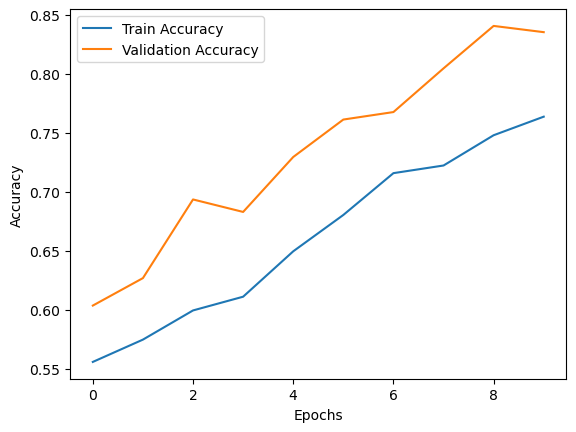

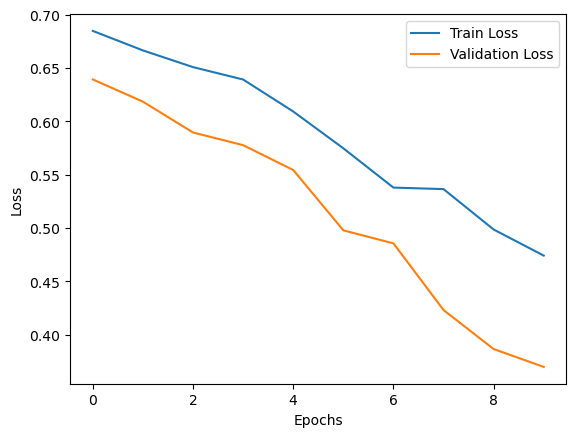

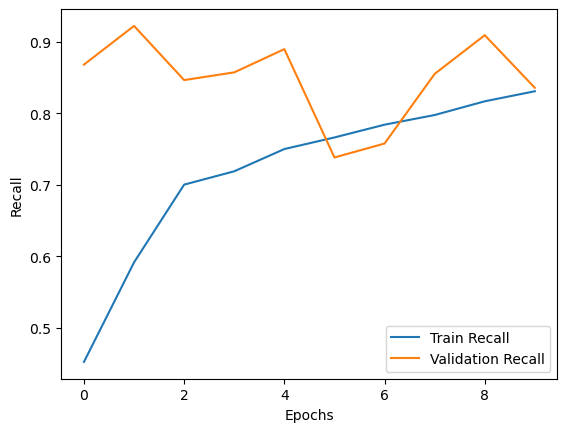

In [60]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['recall_2'], label='Train Recall')
plt.plot(history.history['val_recall_2'], label='Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

### CNN with hyperparameter tuning

In [61]:
loss, acc, precision, recall  = best_model.evaluate(test_generator)
f1_score = 2 * (precision * recall) / (precision + recall + 1e-7)
print(f"Accuracy: {acc:.2f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - accuracy: 0.8306 - loss: 0.3662 - precision: 0.7653 - recall: 0.9451
Accuracy: 0.83
Precision: 0.7690
Recall: 0.9417
F1 Score: 0.8466


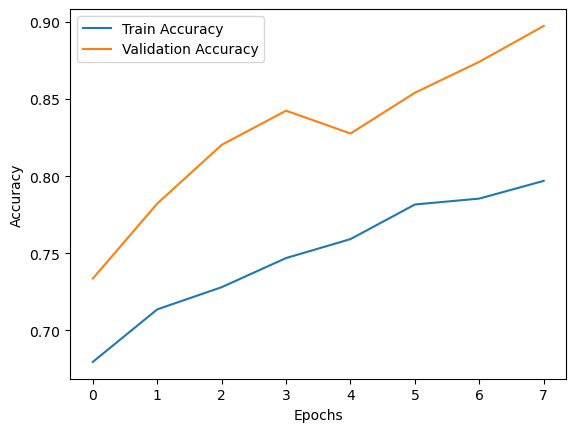

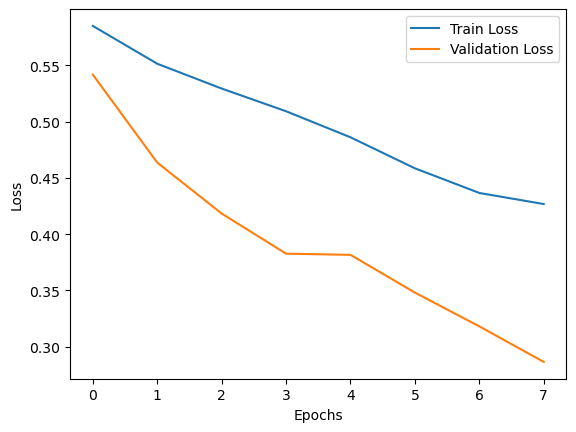

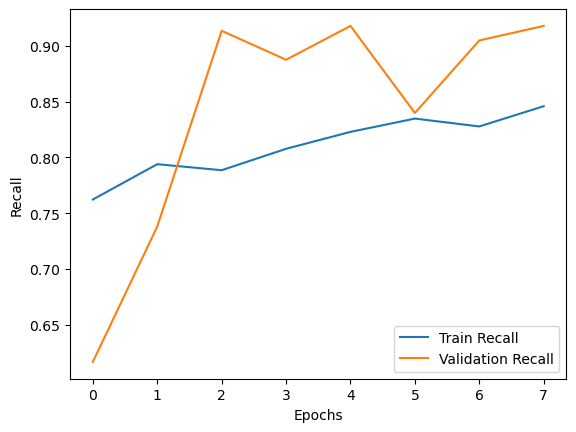

In [62]:
plt.plot(cnn_history.history['accuracy'], label='Train Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(cnn_history.history['loss'], label='Train Loss')
plt.plot(cnn_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(cnn_history.history['recall'], label='Train Recall')
plt.plot(cnn_history.history['val_recall'], label='Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

### Baseline MLP model

In [66]:
# MLP model metrics
mlp_loss, mlp_acc, mlp_precision, mlp_recall = mlp_model.evaluate(test_generator)
mlp_f1_score = 2 * (mlp_precision * mlp_recall) / (mlp_precision + mlp_recall + 1e-7)
print(f"MLP Accuracy: {mlp_acc:.2f}")
print(f"MLP Precision: {mlp_precision:.4f}")
print(f"MLP Recall: {mlp_recall:.4f}")
print(f"MLP F1 Score: {mlp_f1_score:.4f}")

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.5076 - loss: 0.9799 - precision_2: 0.4995 - recall_2: 0.9764
MLP Accuracy: 0.51
MLP Precision: 0.4972
MLP Recall: 0.9698
MLP F1 Score: 0.6574


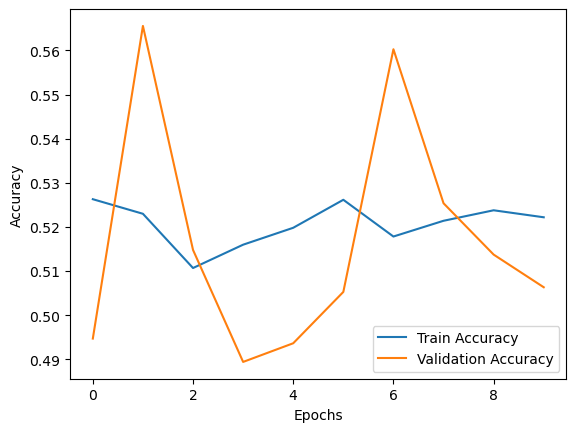

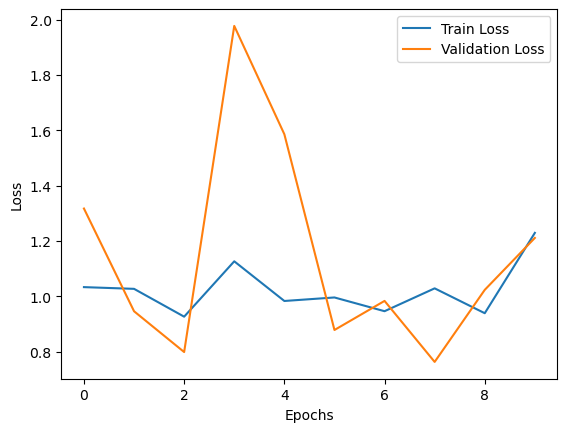

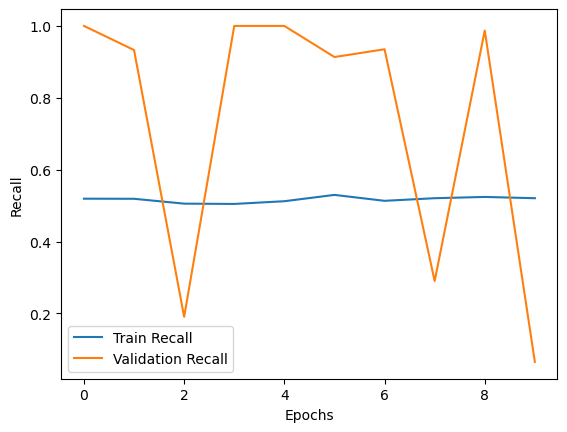

In [64]:
plt.plot(mlp_history.history['accuracy'], label='Train Accuracy')
plt.plot(mlp_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(mlp_history.history['loss'], label='Train Loss')
plt.plot(mlp_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(mlp_history.history['recall_1'], label='Train Recall')
plt.plot(mlp_history.history['val_recall_1'], label='Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()